<h1 style="text-align: center;font-size: 36px;color:darkblue;">Modeling</h1>

# Imports

In [25]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as pyplot
import os
import pickle
import keras
import tensorflow
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils.vis_utils import plot_model
import seaborn

# Configurations

In [3]:
# %matplotlib qt;
%matplotlib inline
pyplot.rcParams["figure.figsize"] = (5, 3)

In [6]:
Training_Data_Path="../Data/Main_Data/Training_Data/"
Testing_Data_Path="../Data/Main_Data/Testing_Data/"

In [7]:
Object_Data_Path="../Data/Preprocessed_Data/"

In [8]:
class_list=os.listdir(Training_Data_Path)

### Functions

In [50]:
def getClassificationEvaluation(actuals:list,predictions:list,labels:list):
    classification_data=confusion_matrix(
    [class_list[i] for i in actuals],
    [class_list[numpy.argmax(prediction)] for prediction in predictions]
    )
    seaborn.heatmap(classification_data,annot=True,xticklabels=labels, yticklabels=labels)
    pyplot.show()
    print(classification_report(
    [class_list[i] for i in actuals],
    [class_list[numpy.argmax(prediction)] for prediction in predictions]
    ))

# Data Import

In [101]:
pickle_training_features=open(Object_Data_Path+"pickle_training_features_1.pickle","rb")
Training_Features=pickle.load(pickle_training_features)
pickle_training_features.close()
pickle_training_labels=open(Object_Data_Path+"pickle_training_labels_1.pickle","rb")
Training_Labels=pickle.load(pickle_training_labels)
pickle_training_labels.close()

In [102]:
Training_Features.shape

(325, 320, 320)

In [103]:
pickle_testing_features=open(Object_Data_Path+"pickle_testing_features_1.pickle","rb")
Testing_Features=pickle.load(pickle_testing_features)
pickle_testing_features.close()
pickle_testing_labels=open(Object_Data_Path+"pickle_testing_labels_1.pickle","rb")
Testing_Labels=pickle.load(pickle_testing_labels)
pickle_testing_labels.close()

In [104]:
Testing_Features.shape

(77, 320, 320)

In [108]:
Total_Testing_Features=numpy.concatenate((Training_Features,Testing_Features))

In [109]:
Total_Testing_Labels=numpy.concatenate((Training_Labels,Testing_Labels))

In [111]:
Total_Testing_Features.shape,Total_Testing_Labels.shape

((402, 320, 320), (402,))

### Praparing Data for Training

#### For Two Dimesion Data

In [119]:
Training_Features=numpy.expand_dims(Training_Features,axis=-1)
Testing_Features=numpy.expand_dims(Testing_Features,axis=-1)

In [120]:
input_dimension=Training_Features[0].shape

#### For Three Dimention Data

# Model Implementaion

In [121]:
input_dimension

(320, 320, 1)

### Model Definition

In [174]:
Model=keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=input_dimension),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Reshape((169,256)),
    keras.layers.LSTM(128,return_sequences=True),
    keras.layers.LSTM(64,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=len(class_list), activation='softmax')
    ]
 )

In [175]:
Model

In [176]:
Model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 106, 106, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 104, 104, 16)      4624      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 52, 52, 16)       0         
 g2D)                                                            
                                                                 
 reshape_8 (Reshape)         (None, 169, 256)          0         
                                                                 
 lstm_16 (LSTM)              (None, 169, 128)        

In [177]:
layer_outputs = [layer.output for layer in Model.layers]

In [188]:
layer_outputs

[<KerasTensor: shape=(None, 318, 318, 32) dtype=float32 (created by layer 'conv2d_30')>,
 <KerasTensor: shape=(None, 106, 106, 32) dtype=float32 (created by layer 'max_pooling2d_40')>,
 <KerasTensor: shape=(None, 104, 104, 16) dtype=float32 (created by layer 'conv2d_31')>,
 <KerasTensor: shape=(None, 52, 52, 16) dtype=float32 (created by layer 'max_pooling2d_41')>,
 <KerasTensor: shape=(None, 169, 256) dtype=float32 (created by layer 'reshape_8')>,
 <KerasTensor: shape=(None, 169, 128) dtype=float32 (created by layer 'lstm_16')>,
 <KerasTensor: shape=(None, 169, 64) dtype=float32 (created by layer 'lstm_17')>,
 <KerasTensor: shape=(None, 10816) dtype=float32 (created by layer 'flatten_14')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_42')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_43')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_44')>]

In [179]:
Model.input

<KerasTensor: shape=(None, 320, 320, 1) dtype=float32 (created by layer 'conv2d_30_input')>

In [189]:
feature_map_model = tensorflow.keras.models.Model(inputs=Model.input, outputs=layer_outputs)

In [190]:
feature_map_model

In [191]:
Total_Testing_Features[0].shape

(320, 320)

In [203]:
feature_maps=feature_map_model.predict(numpy.expand_dims(Total_Testing_Features[0],axis=0))

1/1 [==============================] - 0s 53ms/step


In [199]:
feature_map_model

In [201]:
layer_names = [layer.name for layer in Model.layers]

In [208]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d_30 is =======>> (1, 318, 318, 32)
The shape of the max_pooling2d_40 is =======>> (1, 106, 106, 32)
The shape of the conv2d_31 is =======>> (1, 104, 104, 16)
The shape of the max_pooling2d_41 is =======>> (1, 52, 52, 16)
The shape of the reshape_8 is =======>> (1, 169, 256)
The shape of the lstm_16 is =======>> (1, 169, 128)
The shape of the lstm_17 is =======>> (1, 169, 64)
The shape of the flatten_14 is =======>> (1, 10816)
The shape of the dense_42 is =======>> (1, 512)
The shape of the dense_43 is =======>> (1, 64)
The shape of the dense_44 is =======>> (1, 3)


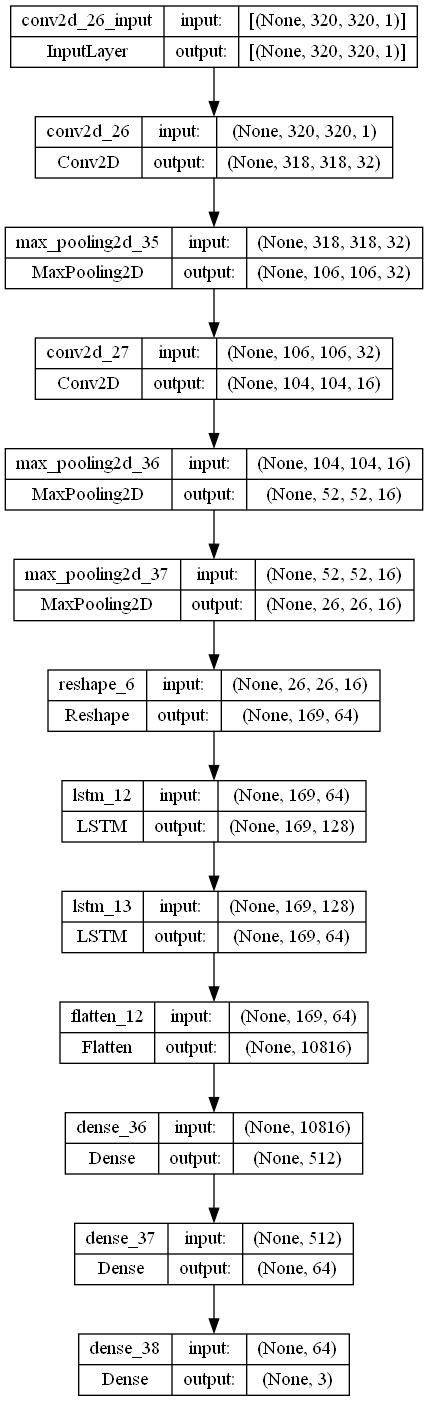

In [97]:
plot_model(Model, to_file='./Graphs/defined_model_1_plot.png', show_shapes=True, show_layer_names=True)

## Training

In [155]:
Model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [156]:
Model.fit(
    Training_Features,Training_Labels,
    epochs=2,
    verbose=1,
    validation_data=(Testing_Features,Testing_Labels)
)

Epoch 1/2
11/11 [==============================] - 17s 1s/step - loss: 1.0147 - accuracy: 0.4677 - val_loss: 1.1921 - val_accuracy: 0.4805
Epoch 2/2
11/11 [==============================] - 16s 1s/step - loss: 0.9131 - accuracy: 0.6185 - val_loss: 0.9776 - val_accuracy: 0.5455


# Model Evaluation

### Training Evaluation

In [123]:
Training_Predictions=Model.predict(Training_Features)

11/11 [==============================] - 4s 283ms/step


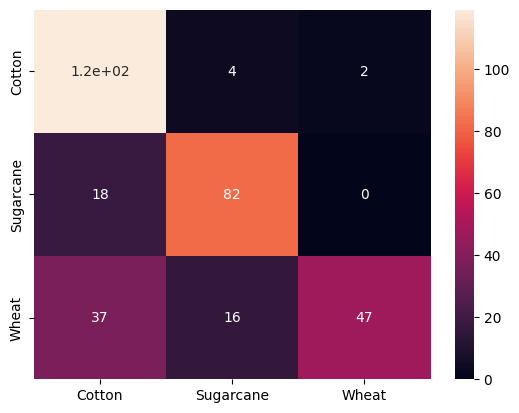

              precision    recall  f1-score   support

      Cotton       0.68      0.95      0.80       125
   Sugarcane       0.80      0.82      0.81       100
       Wheat       0.96      0.47      0.63       100

    accuracy                           0.76       325
   macro avg       0.82      0.75      0.75       325
weighted avg       0.81      0.76      0.75       325



In [124]:
getClassificationEvaluation(Training_Labels,Training_Predictions,class_list)

### Testing Evaluation

In [125]:
Testing_Predictions=Model.predict(Testing_Features)

3/3 [==============================] - 1s 203ms/step


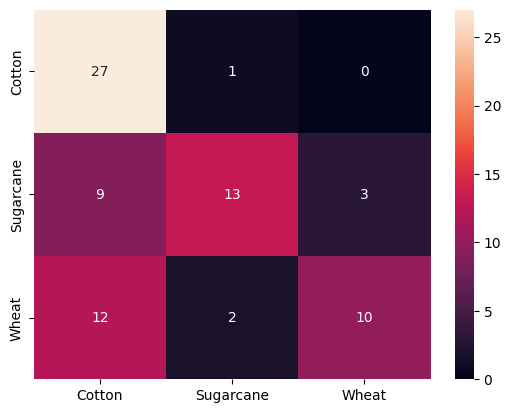

              precision    recall  f1-score   support

      Cotton       0.56      0.96      0.71        28
   Sugarcane       0.81      0.52      0.63        25
       Wheat       0.77      0.42      0.54        24

    accuracy                           0.65        77
   macro avg       0.71      0.63      0.63        77
weighted avg       0.71      0.65      0.63        77



In [126]:
getClassificationEvaluation(Testing_Labels,Testing_Predictions,class_list)

### Overall Testing 

In [127]:
Total_Testing_Predictions=Model.predict(Total_Testing_Features)

13/13 [==============================] - 4s 304ms/step


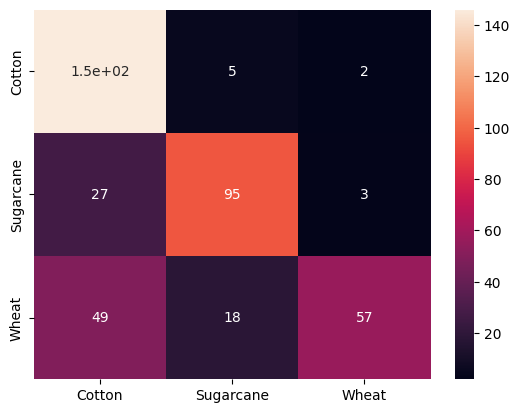

              precision    recall  f1-score   support

      Cotton       0.66      0.95      0.78       153
   Sugarcane       0.81      0.76      0.78       125
       Wheat       0.92      0.46      0.61       124

    accuracy                           0.74       402
   macro avg       0.79      0.72      0.72       402
weighted avg       0.78      0.74      0.73       402



In [128]:
getClassificationEvaluation(Total_Testing_Labels,Total_Testing_Predictions,class_list)

### Saving Temporary Model

In [129]:
Model.save("./Models/DefinedModel_1.h5")

# Model Saving

In [130]:
Model.save("../Model/DefinedModel_2.h5")